# Setup

This notebook deomstrates how to create a basic `nipype` pipeline with `QUIT` programs. The `nanslice` package will be used to display the outputs.

This pipeline downloads the BrainWeb "crisp" brain phantom from http://brainweb.bic.mni.mcgill.ca. It then replaces the tissue classification labels with values of Proton Density and T1, simulates an SPGR/FLASH image with some added noise, and finally uses that simulated data to fit for T1 and PD again.

## Imports and Data Fetching

In [1]:
%matplotlib inline
from QUIT.interfaces.relax import DESPOT1, DESPOT1Sim, DESPOT2
from nanslice import Layer
import nanslice.jupyter as ns
import nibabel as nib
import numpy as np
import requests
import gzip
import os.path

In [2]:
if not os.path.isfile('classes.mnc'): 
    params = {'download_for_real':'[Start Download!]',
              'do_download_alias':'phantom_1.0mm_normal_crisp',
              'format_value':'minc',
              'who_name': 'Tobias Wood',
              'who_institution': 'KCL',
              'who_email': 'tobias.wood@kcl.ac.uk'}
    response = requests.get(url='http://brainweb.bic.mni.mcgill.ca/cgi/brainweb1', params=params)
    minc_file = open('classes.mnc', 'wb')
    minc_file.write(response.content)
classes = Layer('classes.mnc')

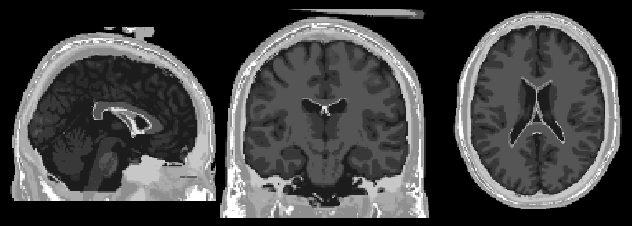

In [3]:
ns.three_plane(classes)

## Create Reference Data

In [3]:
# 0=Background
# 1=CSF
# 2=Grey Matter
# 3=White Matter
# 4=Fat
# 5=Muscle/Skin
# 6=Skin
# 7=Skull
# 8=Glial Matter
# 9=Connective
PDvals = np.array([0, 1, 0.8, 0.7, 0, 0, 0, 0, 0, 0])
T1vals = np.array([0, 3.0, 1.1, 0.9, 0, 0, 0, 0, 0, 0])
class_data = classes.image.get_data().astype('int32')
PDdata = np.choose(class_data, PDvals).astype('float32')
T1data = np.choose(class_data, T1vals).astype('float32')
# PDdata = np.array(list(map(PDFunc, classes.image.get_data())))
PDimage = nib.nifti1.Nifti1Image(PDdata, affine=classes.image.affine)
T1image = nib.nifti1.Nifti1Image(T1data, affine=classes.image.affine)
nib.save(PDimage, 'PD.nii.gz')
nib.save(T1image, 'T1.nii.gz')

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  del sys.path[0]


## Simulate and Display Image

In [4]:
d1seq = {'SPGR': {'TR': 10e-3, 'FA': [3, 18]}}
d1sim = DESPOT1Sim(sequence=d1seq, in_file='sim_spgr.nii.gz', noise=0.001, PD='PD.nii.gz', T1='T1.nii.gz')
d1sim_result = d1sim.run()

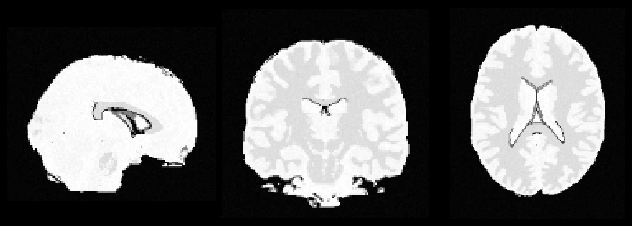

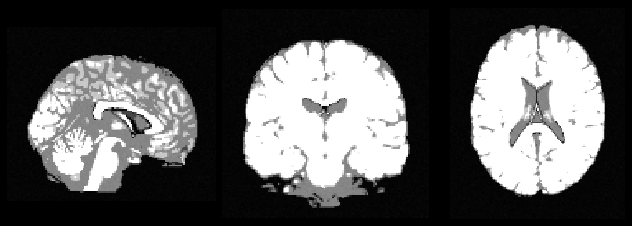

In [6]:
spgr = Layer(d1sim_result.outputs.out_file, volume=0)
display(ns.three_plane(spgr))
spgr.volume = 1
display(ns.three_plane(spgr))

## Run DESPOT1 and Compare Results to Reference

In [ ]:
d1 = DESPOT1(sequence=d1seq, in_file='sim_spgr.nii.gz')
d1_result = d1.run()

In [ ]:
display(ns.three_plane(Layer('PD.nii.gz', label='PD (Arb Units)'), cbar=True))
display(ns.three_plane(Layer('T1.nii.gz', clim=(0, 2.0), cmap='plasma', label='T1 (s)'), cbar=True))

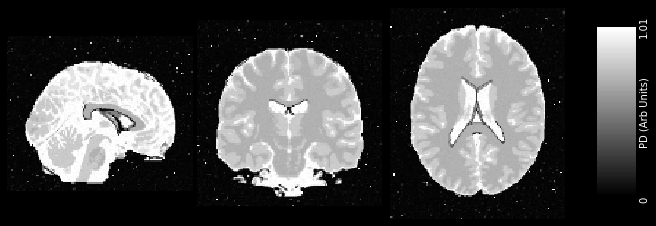

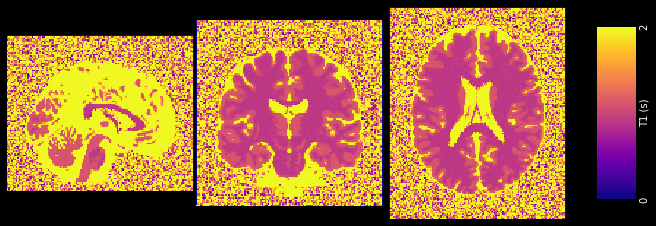

In [9]:
display(ns.three_plane(Layer('D1_PD.nii.gz', label='PD (Arb Units)'), cbar=True))
display(ns.three_plane(Layer('D1_T1.nii.gz', clim=(0, 2.0), cmap='plasma', label='T1 (s)'), cbar=True))